In [5]:
import pandas as pd
from google.colab import drive

drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
import numpy as np
from geopy.distance import geodesic

In [ ]:
file_path = "/drive/My Drive/nb.csv"
df = pd.read_csv(file_path)

In [6]:
# Load the datasets
df_completed_orders = pd.read_csv('../drive/My Drive/completed_orders_cleaned_with_weather_feature_engineered.csv')
df_delivery_requests = pd.read_csv('../drive/My Drive/delivery_requests_cleaned_feature_engineered.csv')

In [11]:
df_delivery_requests

,id,order_id,driver_id,driver_action,lat,lng,driver_action_encoded,lat_scaled,lng_scaled,lat_rad,lng_rad,orders_within_500m,cluster
0,1,392001,243828,accepted,6.602207,3.270465,0,0.149144,0.035652,0.115230,0.057080,322,1
1,2,392001,243588,rejected,6.592097,3.287445,1,0.141327,0.038774,0.115054,0.057377,975,1
2,3,392001,243830,rejected,6.596133,3.281784,1,0.144448,0.037733,0.115124,0.057278,364,1
3,4,392001,243539,rejected,6.596142,3.280526,1,0.144455,0.037502,0.115124,0.057256,390,1
4,5,392001,171653,rejected,6.609232,3.288800,1,0.154577,0.039023,0.115353,0.057400,709,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557735,1557736,517948,243774,rejected,6.469036,3.566877,1,0.046167,0.090151,0.112906,0.062254,1512,2
1557736,1557737,517948,245447,rejected,6.425431,3.527358,1,0.012449,0.082885,0.112145,0.061564,1645,2
1557737,1557738,517948,239866,rejected,6.440013,3.525378,1,0.023724,0.082521,0.112399,0.061529,5678,2
1557738,1557739,517948,243774,rejected,6.469036,3.566877,1,0.046167,0.090151,0.112906,0.062254,1512,2


In [7]:
# Compute geodesic distance between Trip Origin and Trip Destination
def compute_geodesic_distance(origin, destination):
    try:
        origin_coords = tuple(map(float, origin.split(',')))
        destination_coords = tuple(map(float, destination.split(',')))
        return geodesic(origin_coords, destination_coords).kilometers
    except ValueError:
        return np.nan

df_completed_orders['distance_km'] = df_completed_orders.apply(lambda row: compute_geodesic_distance(row['Trip Origin'], row['Trip Destination']), axis=1)

# Compute driving speed
df_completed_orders['driving_speed_kmph'] = df_completed_orders['distance_km'] / (df_completed_orders['trip_duration'] / 60)



In [8]:
# Save the updated DataFrame in the same directory as the notebook
df_completed_orders.to_csv('completed_orders_with_distance_speed.csv', index=False)


In [7]:
from joblib import Parallel, delayed
import numpy as np
from sklearn.neighbors import BallTree

def count_neighbors(tree, coord, radius):
    return len(tree.query_radius([coord], r=radius / 6371)[0]) - 1

def compute_orders_within_radius(df, radius=0.5, n_jobs=-1):
    # Convert lat/lng to radians for BallTree
    df['lat_rad'] = np.deg2rad(df['lat'])
    df['lng_rad'] = np.deg2rad(df['lng'])
    coords = df[['lat_rad', 'lng_rad']].values
    tree = BallTree(coords, metric='haversine')

    # Parallel processing to count neighbors
    counts_within_radius = Parallel(n_jobs=n_jobs)(delayed(count_neighbors)(tree, coord, radius) for coord in coords)

    return counts_within_radius

df_delivery_requests['orders_within_500m'] = compute_orders_within_radius(df_delivery_requests)


In [8]:
# Save the updated dataframe
df_delivery_requests.to_csv('delivery_requests_with_radius_counts.csv', index=False)

In [15]:
from sklearn.cluster import KMeans

def compute_clusters(df_delivery_requests, n_clusters=5):
    coords = df_delivery_requests[['lat', 'lng']].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)
    df_delivery_requests['cluster'] = kmeans.labels_
    return kmeans.cluster_centers_

# Compute clusters for delivery starting locations
start_clusters = compute_clusters(df_delivery_requests)

# # Compute clusters for delivery destinations
# end_clusters = compute_clusters(df_completed_orders)

# Save the updated dataframes
df_delivery_requests.to_csv('delivery_requests_with_clusters.csv', index=False)
df_completed_orders.to_csv('completed_orders_with_clusters.csv', index=False)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
!pip install datashader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 12.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


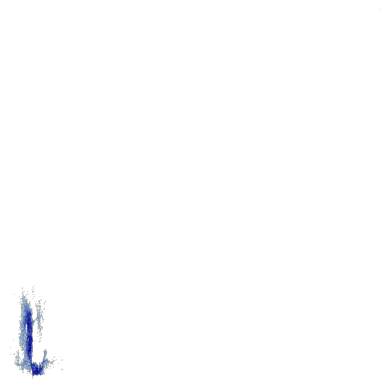

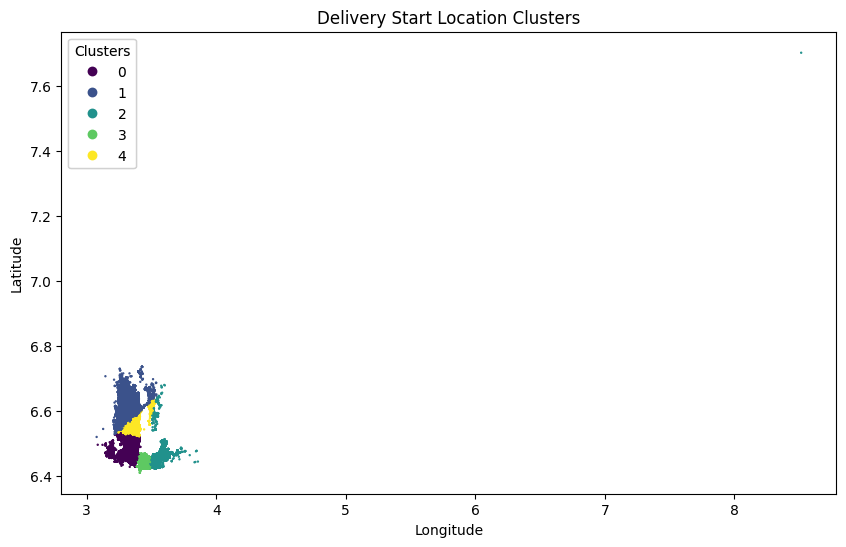

In [17]:
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
df_completed_orders = pd.read_csv('completed_orders_with_clusters.csv')
df_delivery_requests = pd.read_csv('delivery_requests_with_clusters.csv')

# Plot delivery starting locations
cvs = ds.Canvas(plot_width=800, plot_height=800)
agg = cvs.points(df_delivery_requests, 'lng', 'lat', ds.count())
img = tf.shade(agg, cmap=["lightblue", "darkblue"])

# Display the image
plt.imshow(img.to_pil())
plt.axis('off')
plt.show()

# Plot delivery clusters
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df_delivery_requests['lng'], df_delivery_requests['lat'], c=df_delivery_requests['cluster'], cmap='viridis', s=0.5)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delivery Start Location Clusters')
plt.show()


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
df_completed_orders = pd.read_csv('completed_orders_with_distance_speed.csv')
df_delivery_requests = pd.read_csv('delivery_requests_with_radius_counts.csv')

# Split the data
train_orders, holdout_orders = train_test_split(df_completed_orders, test_size=0.2, random_state=42)
train_requests, holdout_requests = train_test_split(df_delivery_requests, test_size=0.2, random_state=42)

# Save the splits
train_orders.to_csv('train_orders.csv', index=False)
holdout_orders.to_csv('holdout_orders.csv', index=False)
train_requests.to_csv('train_requests.csv', index=False)
holdout_requests.to_csv('holdout_requests.csv', index=False)


In [19]:
target_variable = 'order_completion_status'  # Define the target variable
features = [
    'start_hour', 'start_day', 'end_hour', 'end_day', 'trip_duration',
    'distance_km', 'driving_speed_kmph', 'tavg', 'tmin', 'tmax', 'prcp',
    'wdir', 'wspd', 'pres', 'rain', 'weekend', 'holiday'
]


In [21]:
!pip install causalnex


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.3/817.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_

In [20]:
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.plot import plot_structure, NODE_STYLE, EDGE_STYLE
import matplotlib.pyplot as plt

# Create the causal graph
sm = from_pandas(train_orders[features + [target_variable]], w_threshold=0.8)

# Plot the graph
viz = plot_structure(
    sm,
    graph_attributes={"scale": "1.5", "size": "10!"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK
)
viz.draw('causal_graph.png')
plt.show()


ModuleNotFoundError: No module named 'causalnex'